In [1]:
# Cell 1: Import libraries and set seeds for reproducibility.
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pydicom
import cv2

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ Libraries imported and seeds set!")


✅ Libraries imported and seeds set!


In [2]:
# Cell 2: Load dataset metadata and split data into training and validation sets.
dataset_path = "/kaggle/input/rsna-pneumonia-detection-challenge"
train_labels_csv = os.path.join(dataset_path, "stage_2_train_labels.csv")
class_info_csv = os.path.join(dataset_path, "stage_2_detailed_class_info.csv")

# Read CSV files
labels_df = pd.read_csv(train_labels_csv)
class_info_df = pd.read_csv(class_info_csv)

# Merge on 'patientId' and simplify labels (0: Normal, 1: Pneumonia)
merged_df = pd.merge(labels_df, class_info_df, on="patientId")
labels_simple = merged_df[['patientId', 'Target']].drop_duplicates().reset_index(drop=True)
labels_simple['Target'] = labels_simple['Target'].map({0: 'Normal', 1: 'Pneumonia'})
labels_simple['patientId'] = labels_simple['patientId'].astype(str) + ".dcm"

# Split data (80% train, 20% validation), stratified by target.
train_df, val_df = train_test_split(labels_simple, test_size=0.2, random_state=SEED, stratify=labels_simple['Target'])
print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))


Train samples: 21347
Validation samples: 5337


In [3]:
# Cell 3: Define a function to load and preprocess DICOM images.
def load_preprocess_dicom(dicom_path, img_size=(240,240)):
    dicom_data = pydicom.dcmread(dicom_path)
    img_array = dicom_data.pixel_array.astype(np.float32)
    # Normalize pixel values to [0,1]
    img_norm = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array) + 1e-10)
    # Resize image
    img_resized = cv2.resize(img_norm, img_size)
    # Convert grayscale to 3-channel RGB
    img_rgb = np.stack([img_resized]*3, axis=-1)
    return img_rgb

# Test the function on a sample image
sample_image_path = os.path.join(dataset_path, "stage_2_train_images", train_df.iloc[0]['patientId'])
sample_img = load_preprocess_dicom(sample_image_path)
print("✅ Sample image shape (should be 240x240x3):", sample_img.shape)


✅ Sample image shape (should be 240x240x3): (240, 240, 3)


In [4]:
# Cell 4: Create data generators for training and validation.
def data_generator(df, batch_size=64, img_size=(240,240), infinite=True):
    def gen():
        if infinite:
            while True:
                shuffled_df = df.sample(frac=1).reset_index(drop=True)
                for _, row in shuffled_df.iterrows():
                    patient_id = row['patientId']
                    label = 1 if row['Target'] == 'Pneumonia' else 0
                    dicom_path = os.path.join(dataset_path, "stage_2_train_images", patient_id)
                    img = load_preprocess_dicom(dicom_path, img_size)
                    yield img, label
        else:
            for _, row in df.iterrows():
                patient_id = row['patientId']
                label = 1 if row['Target'] == 'Pneumonia' else 0
                dicom_path = os.path.join(dataset_path, "stage_2_train_images", patient_id)
                img = load_preprocess_dicom(dicom_path, img_size)
                yield img, label

    ds = tf.data.Dataset.from_generator(
        gen,
        output_types=(tf.float32, tf.int32),
        output_shapes=((img_size[0], img_size[1], 3), ())
    )
    ds = ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

BATCH_SIZE = 64
train_ds = data_generator(train_df, batch_size=BATCH_SIZE, img_size=(240,240), infinite=True)
val_ds = data_generator(val_df, batch_size=BATCH_SIZE, img_size=(240,240), infinite=False)
print("✅ Data generators created with batch size:", BATCH_SIZE)


✅ Data generators created with batch size: 64


In [5]:
    # Cell 5: Compute class weights to mitigate class imbalance.
    y_train = train_df['Target'].apply(lambda x: 1 if x == 'Pneumonia' else 0)
    weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = {i: w for i, w in enumerate(weights)}
    print("✅ Class weights computed:", class_weights)


✅ Class weights computed: {0: 0.6454314567333858, 1: 2.219022869022869}


In [6]:
# Cell 9: Load Best Hyperparameters and Build the Final Model

import json
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the best hyperparameters from JSON
with open("/kaggle/input/best-hyperparameters/best_hyperparameters.json", "r") as f:
    best_params = json.load(f)

print("✅ Best hyperparameters loaded:", best_params)

# Build the base DenseNet201 model with ImageNet weights (exclude the top)
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

# Set trainability based on the 'unfreeze' hyperparameter
base_model.trainable = best_params["unfreeze"]

# Build the custom classification layers on top
inputs = Input(shape=(240, 240, 3))
x = base_model(inputs, training=False)  # Ensure the base is in inference mode
x = GlobalAveragePooling2D()(x)
x = Dense(best_params["dense_units"], activation='relu')(x)
x = Dropout(best_params["dropout"])(x)
# For binary classification, use a single output neuron with sigmoid activation
outputs = Dense(1, activation='sigmoid')(x)

# Assemble the final model
final_model = Model(inputs, outputs)

# Compile the model with the tuned learning rate
optimizer = Adam(learning_rate=best_params["lr"])
final_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display the final model summary
final_model.summary()


✅ Best hyperparameters loaded: {'unfreeze': True, 'dense_units': 64, 'dropout': 0.30000000000000004, 'lr': 0.00010733251249694184}
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet201 (Functional)             │ (None, 7, 7, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         122,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,444,993 (70.36 MB)

 Trainable params: 18,215,937 (69.49 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [7]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the number of epochs for final training
EPOCHS_FINAL = 50  # Increased, but early stopping will prevent overfitting

# Calculate steps per epoch
steps_per_epoch = math.ceil(len(train_df) / BATCH_SIZE)

# Add EarlyStopping and ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # Stop if val_loss increases for 5 epochs
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)   # Reduce LR if no improvement in 3 epochs
]

# Train the model with added callbacks
history_final = final_model.fit(
    train_ds,
    epochs=EPOCHS_FINAL,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7409 - loss: 0.5237

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


334/334 ━━━━━━━━━━━━━━━━━━━━ 974s 2s/step - accuracy: 0.7410 - loss: 0.5236 - val_accuracy: 0.7928 - val_loss: 0.4450 - learning_rate: 1.0733e-04
Epoch 2/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.8027 - loss: 0.4173 - val_accuracy: 0.7798 - val_loss: 0.4510 - learning_rate: 1.0733e-04
Epoch 3/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - accuracy: 0.8218 - loss: 0.3547 - val_accuracy: 0.7993 - val_loss: 0.4123 - learning_rate: 1.0733e-04
Epoch 4/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 400s 1s/step - accuracy: 0.8660 - loss: 0.2725 - val_accuracy: 0.8169 - val_loss: 0.4221 - learning_rate: 1.0733e-04
Epoch 5/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 337s 1s/step - accuracy: 0.8981 - loss: 0.2256 - val_accuracy: 0.7763 - val_loss: 0.5383 - learning_rate: 1.0733e-04
Epoch 6/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.9394 - loss: 0.1465
Epoch 6: ReduceLROnPlateau reducing learning rate to 5.3666255553252995e-05.
334/334 ━━━━━━━━━━━━━━━━━━━━ 311s 933ms/step - accuracy: 0.93

In [8]:
# Cell 11: Evaluate the Final Model

# Evaluate the final model on the validation dataset
loss, accuracy = final_model.evaluate(val_ds)
print("Final model validation accuracy: {:.2f}%".format(accuracy * 100))


84/84 ━━━━━━━━━━━━━━━━━━━━ 63s 623ms/step - accuracy: 0.7977 - loss: 0.4084
Final model validation accuracy: 79.93%


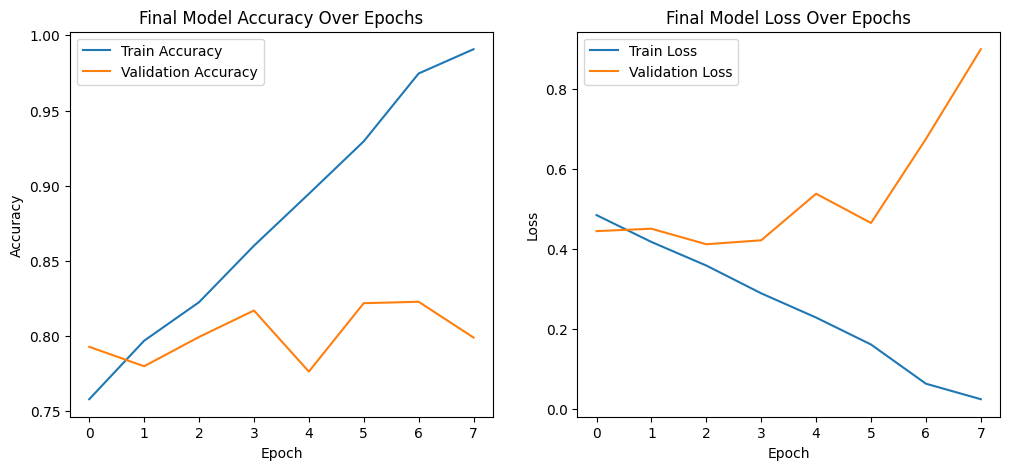

In [9]:
# Cell 12 (Optional): Visualize Training History

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot accuracy over epochs
plt.subplot(1, 2, 1)
plt.plot(history_final.history['accuracy'], label='Train Accuracy')
plt.plot(history_final.history['val_accuracy'], label='Validation Accuracy')
plt.title('Final Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history_final.history['loss'], label='Train Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.title('Final Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


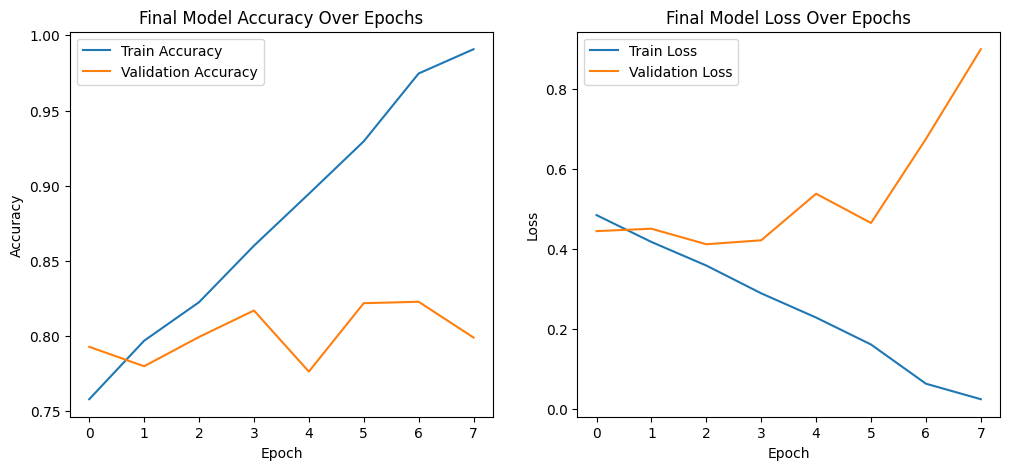

In [10]:
    # Cell 12 (Optional): Visualize Training History
    
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy over epochs
    plt.subplot(1, 2, 1)
    plt.plot(history_final.history['accuracy'], label='Train Accuracy')
    plt.plot(history_final.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Final Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss over epochs
    plt.subplot(1, 2, 2)
    plt.plot(history_final.history['loss'], label='Train Loss')
    plt.plot(history_final.history['val_loss'], label='Validation Loss')
    plt.title('Final Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()


In [ ]:
# Evaluate the model on the validation dataset
loss, accuracy = final_model.evaluate(val_ds)
print("Validation Loss: {:.4f}".format(loss))
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))

# Import additional libraries for evaluation
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Get predictions from the model (y_pred_probs are probabilities)
y_pred_probs = final_model.predict(val_ds)
# Convert probabilities to class predictions (binary classification with threshold 0.5)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

# Retrieve true labels from the val_ds dataset
y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Compute and print the classification report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_true, y_pred_probs)
print("ROC-AUC Score: {:.2f}".format(roc_auc))

# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC curve (area = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()
